In [ ]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download himanshuydv11/facial-emotion-dataset
! unzip facial-emotion-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: facial_emotion_dataset/dataset/Sad/0a12a7e998fa7abde73e79ce2a74477bdc6f5dd010da05231f4c3330.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a1370fc7e34586d5f134694c9d1e79ed4cce9e59684077ae5061db8.png  
  inflating: facial_emotion_dataset/dataset/Sad/0a14abb2a25753914205e88e870054918de36219552002f3144b8455.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a15eede4e05e13f70f6540c4167282f9a488cc318005c8693c49433.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a163aa46984ad37b58aa6b8175dca9b1007a3066099d18f4dda6f78.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a1833eb2427bd8c1ddd3b9c020c6233a3671763e21b1e08b5afa41f.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a19842e87935fbd2c45a7042e4bb8d1d3816476e8a6b7e8f41205d8.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a1d613237e9af295213c61e1c2b9d7fd211fad638c522afb9548901.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a1d86074a08f

In [ ]:
#delete ahegao class
!rm -rf /content/facial_emotion_dataset/dataset/Ahegao
!rm -rf /content/facial_emotion_dataset/dataset/Neutral

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.data import ConcatDataset
data_dir = "/content/facial_emotion_dataset/dataset"
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(len(dataset))
train_size = int(0.7*len(dataset))
val_size  = int(0.2*len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset,[train_size,val_size,test_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset,shuffle=True, batch_size=32)
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
print(dataset.classes)

10221
224
64
32
['Angry', 'Happy', 'Sad', 'Surprise']


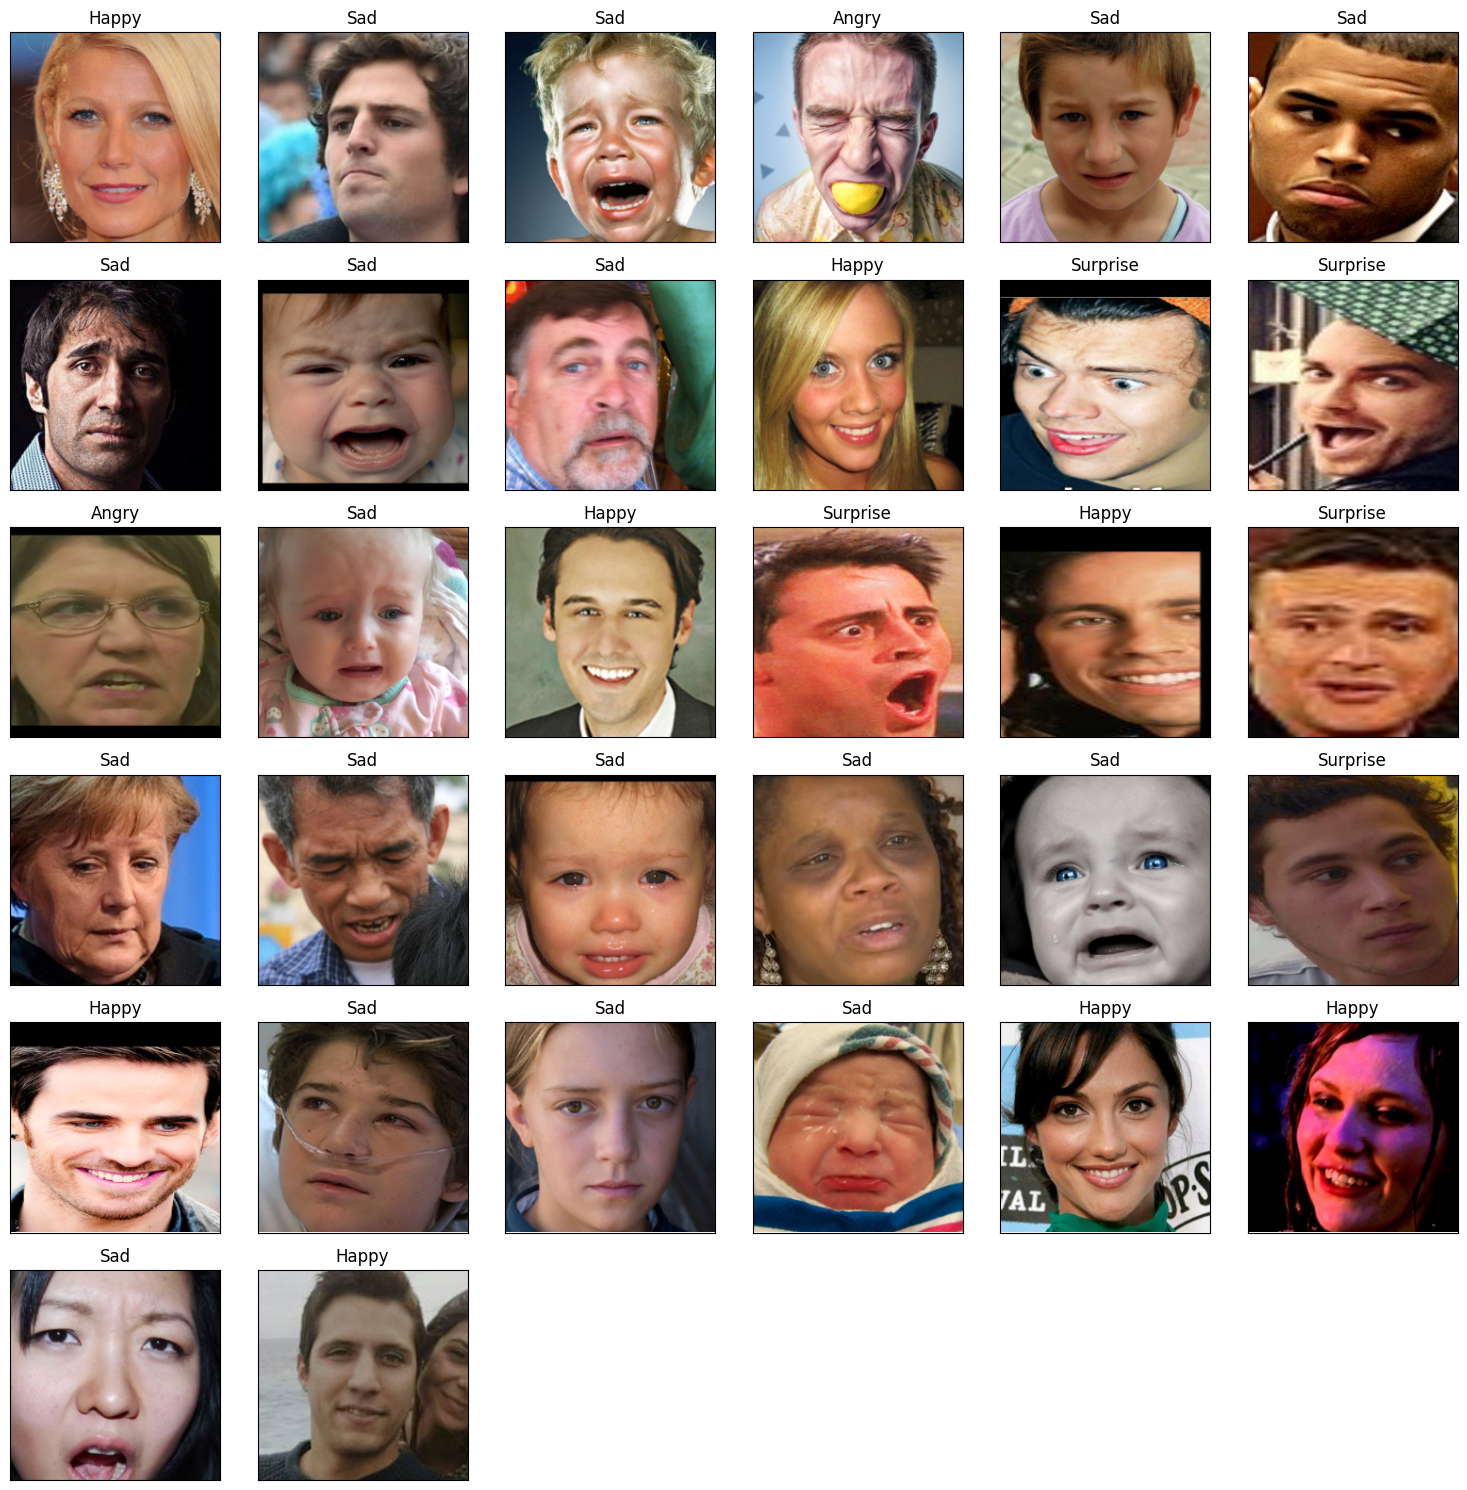

In [ ]:
train_images, train_label = next(iter(train_loader))
class_names = dataset.classes
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
for i in range(32):
    plt.subplot(6,6,i+1)
    plt.imshow(train_images[i].permute(1,2,0).numpy())
    plt.title(f"{class_names[train_label[i]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
class augmenteddataset(torch.utils.data.Dataset):
    def __init__(self,dataset,transform):
        self.original_dataset = dataset
        self.data_augmented = transform
    def __len__(self):
        return len(self.original_dataset)
    def __getitem__(self,index):
        image,label = self.original_dataset[index]
        augmented_image = self.data_augmented(image)
        return augmented_image, label
data_augmentation1 = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0),
                                         transforms.Normalize(mean=(0.485,0.456,0.406),std = (0.229,0.224,0.225))])
data_augmentation2 = transforms.Compose([transforms.RandomRotation(degrees=45),
                                         transforms.Normalize(mean=(0.485,0.456,0.406),std = (0.229,0.224,0.225))])
data_augmentation3 = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.2,p=1.0),
                                         transforms.Normalize(mean=(0.485,0.456,0.406),std = (0.229,0.224,0.225))])
#augmented1 = augmenteddataset(train_dataset,data_augmentation1)
augmented2 = augmenteddataset(train_dataset,data_augmentation2)
augmented3 = augmenteddataset(train_dataset,data_augmentation3)
train_dataset = ConcatDataset([train_dataset,augmented2,augmented3])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset,shuffle=True, batch_size=32)
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

671
64
32


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models,datasets,transforms
torch.cuda.empty_cache()
def accuracy_score(output,label):
    _,preds = torch.max(output,dim=1)
    return torch.tensor(torch.sum(preds==label).item()/len(preds))
# load pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained= True)
#ambil fitur terakhir dari restner
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,5) # 5 class
#save model into GPU
model = model.to(device)
#define loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-4)
#training loop
best_val_loss = float('inf')
best_accuracy = 0.0
early_stop_counter = 0
patience = 3
for epoch in range(5):
    model.train()
    train_loss = 0.0
    #train
    for image,label in train_loader:
        #forward
        image,label = image.to(device), label.to(device)
        output = model(image)
        loss = criterion(output, label)
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    #validation
    model.eval()
    val_loss = 0.0
    accuracy = 0.0
    with torch.no_grad():
        for image,label in val_loader:
            image,label = image.to(device), label.to(device)
            output = model(image)
            losss = criterion(output, label)
            val_loss += losss.item()
            accuracy += accuracy_score(output,label).item()
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    accuracy = (accuracy/len(val_loader)) *100
    print(f"Epochs [{epoch+1}/5], train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, accuracy: {accuracy:.2f}%")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),"Best_emotion_face_model.pth")
        print(f"Model saved at epoch {epoch + 1} with Best val loss: {best_val_loss:.4f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter > patience:
            print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}, Accuracy: {accuracy:.4f}%")
            break


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs [1/5], train loss: 0.3760, val loss: 0.2583, accuracy: 91.16%
Model saved at epoch 1 with Best val loss: 0.2583
Epochs [2/5], train loss: 0.1592, val loss: 0.3068, accuracy: 90.07%
Epochs [3/5], train loss: 0.0937, val loss: 0.3217, accuracy: 90.76%
Epochs [4/5], train loss: 0.0668, val loss: 0.3541, accuracy: 90.99%
Epochs [5/5], train loss: 0.0629, val loss: 0.3269, accuracy: 91.43%
Early stopping at epoch 5, Best Val Loss: 0.2583, Accuracy: 91.4342%


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models,datasets,transforms
torch.cuda.empty_cache()
def accuracy_score(output,label):
    _,preds = torch.max(output,dim=1)
    return torch.tensor(torch.sum(preds==label).item()/len(preds))
# load pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
#load model
model = models.resnet18(pretrained = False)
model.fc = nn.Linear(model.fc.in_features,5)
model.load_state_dict(torch.load('/content/Best_emotion_face_model.pth'))
model.to(device)
model.eval()
with torch.no_grad():
    accuracyy = 0
    for image,label in test_loader:
        outputs = model(image.to(device))
        accuracyy += accuracy_score(outputs,label.to(device))
        akurasi = (accuracyy/len(test_loader)).item()
    print(f"accuracy: {np.round(akurasi,4)*100}%")

<ipython-input-9-371044781297>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/Best_emotion_face_model.pth'))


accuracy: 95.50999999999999%


In [ ]:
test_images, test_label = next(iter(test_loader))
model.eval()
with torch.no_grad():
  outputs = model(test_images[0].unsqueeze(0).to(device))
  prediction = torch.argmax(outputs, dim = 1).item()
prediction

1

In [ ]:
class_names = dataset.classes
class_names

['Angry', 'Happy', 'Sad', 'Surprise']

In [ ]:
import pickle
with open('class_names_face_recognition.pkl','wb') as f:
  pickle.dump(class_names,f)

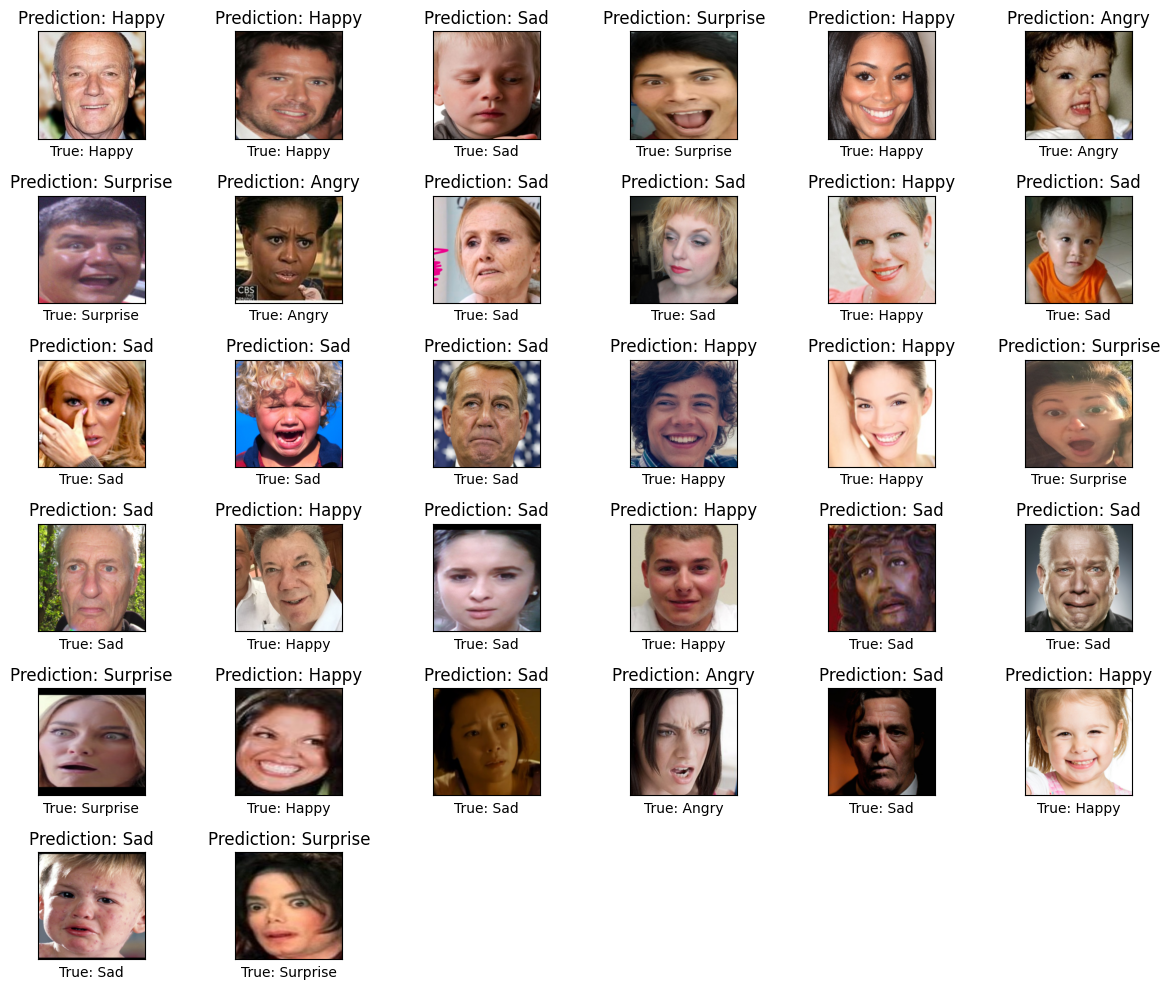

In [ ]:
import matplotlib.pyplot as plt
class_names = dataset.classes
model.eval()
with torch.no_grad():
    plt.figure(figsize=(12,10))
    for i in range(32):
        plt.subplot(6,6,i+1)
        plt.imshow(test_images[i].permute(1,2,0).numpy())
        prediction = torch.argmax(model(test_images[i].unsqueeze(0).to(device)),dim=1).item()
        plt.title(f"Prediction: {class_names[prediction]}")
        plt.xlabel(f"True: {class_names[test_label[i]]}")
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.tight_layout()
    plt.show()